# Feature Analysis Notebook

This Notebook performs an Elastic Net regression to identify gene set properties that drive the observed COLOC score. Further examinations of identified properties are provided. 

**Inputs:**
* Supplemental Table 1 - Input Information (`STable1.tsv`)
* Supplemental Table 2 - NetColoc Results (`STable2.tsv`)
* Supplemental Table 3 - Heritability & Prevalence Estimates (`STable3.tsv`)
* Supplemental Table 4 - Regression Gene Set Features (`STable4.tsv`)
* Gene set enrichment results - (`outputs/gProfiler_hsapiens_5-19-2025_11-22-48 AM__intersections.csv`)

**Figures Generated:**
- Figure 4A
- Figure 4B
- Figure 4C
- Figure 4D
- Figure 4E
- Figure 4F
- SFigure 3A
- SFigure 3B
- SFigure 4C
- Figure 5A
- Figure 5B
- Figure 5D
- SFigure 5

**Tables Generated:**
- Table 1. Regression Coefficients

### Set Up

In [135]:
import pandas as pd
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from statsmodels.stats.multitest import fdrcorrection
import sklearn.preprocessing as prep
import statsmodels.api as sm

import numpy as np
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from scipy.stats import spearmanr
from sklearn.linear_model import ElasticNet

In [136]:
cwd= os.getcwd()

In [137]:
datadir = os.path.join(cwd, '..')

In [138]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.5
import matplotlib.font_manager as fm
arial_font_path = os.path.join(datadir, 'Reference_Data', 'Arial.TTF')
fm.fontManager.addfont(arial_font_path)
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
blue='#6ec1e0'
green='#5fad56'
shared='#af3800'
binary='#00606f'
purple='#441f5d'
raspberry='#b4436c'

In [139]:
feature_names={
    'N_C': 'Study Size - Common',
    'N_R': "Study Size - Rare",
    'assortativity_RC':'Assortativity',
    'g_C': 'Number of Genes - Common',
    'g_R': 'Number of Genes - Rare',
    'J_RC': 'Jaccard Sim.',
    'density_R': 'Subnetwork Density - Rare',
    'density_C': 'Subnetwork Density - Common',
    'binary': 'Is Trait Binary',
    'jaccard_zero': 'No shared genes', 
    'Mean_Constraint': 'Mean Constraint', 
    'DiffRC_Constraint':'Diff. Constraint', 
    'Mean_GeneSize':'Mean Gene Size', 
    'DiffRC_GeneSize':'Diff. Gene Size',
    'Mean_GO': 'Mean GO Terms', 
    'DiffRC_GO': 'Diff. GO Terms', 
    'Mean_mRNA': 'Mean Exp.', 
    'DiffRC_mRNA': 'Diff. Exp.', 
    'Mean_nTissues': 'Mean Exp. Tissues',
    'DiffRC_nTissues': 'Diff. Exp. Tissues'}

In [140]:
def plot_feature_means_by_y_quantile_lines(
    X_df: pd.DataFrame,
    y_df: pd.DataFrame,
    y_col: str,
    group_col: str = None,
    group_order: list = None,
    n_quantiles: int = 10,
    subset_features: list = None,
    feature_name_map: dict = None,
    figsize: tuple = (10, 6),
    colors: list = None,
    ax: plt.Axes = None,
    plot_violin=False,
    markersize=4
):
    """
    Plot feature means ± SEM across either y-quantile bins or predefined groups.
    If plot_violin=True, show a violin of the raw feature-values in each bin 
    (for each feature).

    Parameters
    ----------
    X_df : pd.DataFrame
        Feature DataFrame (n_samples x n_features).
    y_df : pd.DataFrame
        DataFrame containing the target column and optional group column.
    y_col : str
        Name of the column in y_df to use as the continuous target (for quantiles).
    group_col : str, optional
        Name of the column in y_df to use as categorical grouping. If provided,
        samples are grouped by this column instead of quantiles.
    group_order : list of str, optional
        Desired order of categories in group_col. Categories not present are dropped.
    n_quantiles : int, default=10
        Number of equal-sized bins to cut y into (used only if group_col is None).
    subset_features : list of str, optional
        Names of features in X_df to plot. If None, all columns of X_df are used.
    feature_name_map : dict, optional
        Mapping from X_df column names to display names for plotting.
    figsize : tuple, optional
        Matplotlib figure size.
    colors : list of str, optional
        List of colors for each feature line or hue for violins.
    ax : matplotlib.axes.Axes, optional
        Axes object to draw on; if None, a new figure and axes are created.
    plot_violin : bool, default=False
        If True, draw a violinplot of the raw datapoints in each bin (for each feature)
        instead of the mean±SEM lines.
    markersize : int, default=4
        Marker size for the errorbar plot (if plot_violin=False).
    """
    # Join X and y on index
    merged = X_df.join(y_df[[y_col] + ([group_col] if group_col else [])], how='inner')

    # Select which features to plot
    all_features = X_df.columns.tolist()
    features_to_plot = subset_features if subset_features else all_features

    # If feature_name_map is given, build a dict for display
    if feature_name_map:
        display_names = [feature_name_map.get(f, f) for f in features_to_plot]
    else:
        display_names = features_to_plot.copy()

    # Determine grouping (either by group_col or by quantiles of y_col)
    if group_col:
        groups = merged[group_col].astype(str)
        if group_order:
            unique_groups = [g for g in group_order if g in groups.unique()]
        else:
            unique_groups = list(pd.Categorical(groups).categories)

        bin_index = {g: i for i, g in enumerate(unique_groups)}
        bins = groups.map(bin_index).values
        labels = unique_groups
        n_bins = len(unique_groups)

    else:
        y = merged[y_col].values
        try:
            bins = pd.qcut(y, q=n_quantiles, labels=False, duplicates='drop')
        except ValueError:
            # fallback to a rank‐based binning if qcut fails
            rank = np.argsort(np.argsort(y))
            bins = np.floor((rank / len(y)) * n_quantiles).astype(int)
            bins[bins == n_quantiles] = n_quantiles - 1
        unique_bins = np.unique(bins)
        # use percentiles as x‐tick labels
        labels = [int((i + 1) * (100 / n_quantiles)) for i in unique_bins]
        n_bins = len(unique_bins)

    # Extract X as numpy array for mean/SEM computation
    X = merged[features_to_plot].values

    # Compute per‐bin means and SEMs (only used if plot_violin=False)
    means = np.zeros((n_bins, X.shape[1]))
    sems = np.zeros_like(means)
    for i in range(n_bins):
        vals = X[bins == i]
        means[i, :] = vals.mean(axis=0)
        sems[i, :] = vals.std(axis=0, ddof=1) / np.sqrt(len(vals))

    # Create axes if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    x = np.arange(n_bins)
    
    
            # Build a long‐form DataFrame of raw feature‐values with their bin indices
    plot_df = merged[features_to_plot].copy()
    plot_df['bin'] = bins

    # Melt so that each row is: (bin, feature_name, raw_value)
    melted = plot_df.melt(
        id_vars=['bin'],
        value_vars=features_to_plot,
        var_name='feature',
        value_name='value'
    )

    # Map feature → display name if provided
    if feature_name_map:
        melted['feature_display'] = melted['feature'].map(
            lambda f: feature_name_map.get(f, f)
        )
    else:
        melted['feature_display'] = melted['feature']
    

    if not plot_violin:
        # Standard line + errorbar plot of mean ± SEM for each feature
        for idx, name in enumerate(display_names):
            color = colors[idx] if colors and idx < len(colors) else None
            ax.errorbar(
                x,
                means[:, idx],
                yerr=0, #sems[:, idx],
                fmt='-o',
                capsize=3,
                markersize=markersize,
                color=color,
                label=name,
                zorder=10
            )
        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')


    else:

        # Now plot one violin per (bin, feature). Use 'hue' to separate features.
        # If you only passed a single feature, hue will be trivial.
        sns.violinplot(
            x='bin',
            y='value',
            hue='feature_display',
            data=melted,
            palette=colors,
            cut=0,
            ax=ax,
            fill=False,
            inner="quart",
            linewidth=0.5
        )
        # Optionally, if you want to dodge violins per feature side‐by‐side, seaborn will handle it.
        # If you want no legend when only one feature, you can do:
        if len(features_to_plot) == 1:
            ax.get_legend().remove()
        else:
            ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

    # Final formatting
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_xlabel(group_col if group_col else y_col)
    ax.set_ylabel("Feature value" if plot_violin else "Mean feature value")
    title = (
        f"Feature means ± SEM across groups '{group_col}'"
        if group_col else
        f"Feature means ± SEM across {n_quantiles} Y quantiles"
    )


    # Return a small DataFrame for debugging / further use if desired
    z = pd.DataFrame({'y': merged[y_col].values, 'bin': bins})
    return z, melted

### Load Data

In [141]:
all_feat = pd.read_csv(os.path.join(datadir, 'outputs/STable4.tsv'), sep='\t')
all_feat.columns

Index(['trait_pair', 'EFO', 'Common Study', 'Rare Study', 'g_C', 'g_R',
       'nShared', 'Log2SizeOE', 'J_RC', 'jaccard_zero', 'N_C', 'N_R', 'binary',
       'Mean_Constraint', 'DiffRC_Constraint', 'Mean_GO', 'DiffRC_GO',
       'Mean_GeneSize', 'DiffRC_GeneSize', 'Mean_mRNA', 'DiffRC_mRNA',
       'Mean_nTissues', 'DiffRC_nTissues', 'density_R', 'density_C',
       'assortativity_RC'],
      dtype='object')

In [142]:
all_feat.shape

(1634, 26)

In [144]:
h2_prev = pd.read_csv(os.path.join(datadir, 'outputs/STable3.tsv'), sep='\t')
prev_df = h2_prev.dropna(subset='5 Year Prevalence').drop(columns=['SNP-Heritability'])
h2_df = h2_prev.dropna(subset='SNP-Heritability').drop(columns=['5 Year Prevalence'])

In [145]:
def get_trait_pair(df):
    df['trait_pair'] = df['Rare Study'].astype(int).astype(str) + '_' + df['EFO'] +'_' +df['Common Study'] +'_'+ df['EFO']
    return df

In [146]:
coloc_df = pd.read_csv(os.path.join(datadir, 'outputs/STable2.tsv'), sep='\t')
coloc_df = get_trait_pair(coloc_df)
best_df = coloc_df[coloc_df['Optimal COLOC']].copy()

In [147]:
all_feat = all_feat.dropna()

In [148]:
all_feat = get_trait_pair(all_feat)

## Heritability and Prevalence Analysis

In [149]:
all_feat2 = all_feat.copy()
all_feat_h2 = h2_df.merge(all_feat2, on=['EFO'], how='left')
all_feat_prev = prev_df.merge(all_feat2, on='EFO', how='left')

In [150]:
all_feat_h2 = all_feat_h2[all_feat_h2.trait_pair.isin(best_df.trait_pair.values)]
all_feat_prev = all_feat_prev[all_feat_prev.trait_pair.isin(best_df.trait_pair.values)]

### Figure 4A - Heritability

In [152]:
all_feat_h2.loc[:, ('Log2SizeOE', 'SNP-Heritability')].corr(method='spearman')
r_h2 = all_feat_h2.loc[:, ('Log2SizeOE', 'SNP-Heritability')].corr(method='spearman').at['Log2SizeOE', 'SNP-Heritability']


In [153]:
all_feat_h2.shape

(197, 27)

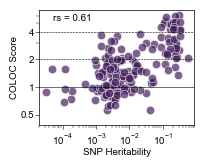

In [155]:
_ = plt.figure(figsize=(2,1.5))
sns.scatterplot(all_feat_h2, y='Log2SizeOE', x='SNP-Heritability', alpha=0.7, color=purple)
plt.hlines(y=0, xmin=-0.05, xmax=0.9, color='black', linewidth=0.4)
plt.hlines(y=[1, 2], xmin=-0.05, xmax=0.9, color='black', linewidth=0.4, linestyle='--')
plt.xlim(0.00002, 0.9)
ax1 = plt.gca()
ax1.set_yticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
_ = ax1.set_yticks(np.log2([3,5,6]), minor=True)
_ =ax1.set_ylabel('COLOC Score')
_ =ax1.set_xlabel('SNP Heritability')
_ = plt.text(x=0.00005, y=2.4, s=f'rs = {r_h2:.2f}')
plt.xscale('log')

### Figure 4B - Prevalence

In [156]:
all_feat_prev.loc[:, ('Log2SizeOE','5 Year Prevalence', 'g_C', 'g_R')].corr(method='spearman')
r_prev = all_feat_prev.loc[:, ('Log2SizeOE','5 Year Prevalence')].corr(method='spearman').at['Log2SizeOE', '5 Year Prevalence']
all_feat_prev.shape

(87, 27)

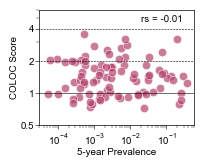

In [157]:
_ = plt.figure(figsize=(2,1.5))
sns.scatterplot(all_feat_prev, y='Log2SizeOE', x='5 Year Prevalence', alpha=0.7, color=raspberry)
plt.hlines(y=0, xmin=-0.05, xmax=0.6, color='black', linewidth=0.4)
plt.hlines(y=[1, 2], xmin=-0.05, xmax=0.6, color='black', linewidth=0.4, linestyle='--')
plt.xlim(.00003, 0.6)
ax1 = plt.gca()
ax1.set_yticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
_ = ax1.set_yticks(np.log2([3,5,6]), minor=True)
_ =ax1.set_ylabel('COLOC Score')
_ =ax1.set_xlabel('5-year Prevalence')
_ = plt.text(x=0.02, y=2.2, s=f'rs = {r_prev:.2f}')
plt.xscale('log')

### SFigure 3A - Domain heritability and gene counts

In [158]:
st1 = pd.read_csv(os.path.join(datadir, 'outputs/STable1.tsv'), sep='\t')

In [159]:
domain_info = st1.loc[:, ['Mapped EFO', 'Biological Domain']].drop_duplicates()
domain_info.columns=['EFO', 'Domain']

In [160]:
best_h2 = best_df[best_df.EFO.isin(all_feat_h2.EFO)].copy()
best_h2= best_h2.merge(all_feat_h2.loc[:, ('EFO', 'SNP-Heritability')]).merge(domain_info, on=['EFO'])

In [161]:
h2_order = best_h2.groupby('Domain').Log2SizeOE.median().sort_values(ascending=False).index

In [162]:
best_h2['SizeOE'] = best_h2.Log2SizeOE.apply(lambda x: 2**x)

In [163]:
best_h2['Domain'] = best_h2['Domain'].apply(lambda x: 'Other' if x in ['Hepatic', 'Pain'] else x)

In [164]:
def get_mean_and_sem_per_domain(initial_df, x_col, y_col):
    plt_df = initial_df.loc[:, ('Domain', x_col, y_col)].groupby('Domain').mean().reset_index()
    plt_sem = initial_df.loc[:, ('Domain', x_col, y_col)].groupby('Domain').sem().reset_index()
    plt_df = plt_df.merge(plt_sem, on='Domain', suffixes=('_mean', '_sem'))
    plt_df['x_high'] = plt_df.apply(lambda x: x[x_col + '_mean'] + x[x_col+'_sem'], axis=1)
    plt_df['x_low'] = plt_df.apply(lambda x: max(x[x_col + '_mean'] - x[x_col+'_sem'], 0), axis=1)
    plt_df['y_high'] = plt_df.apply(lambda x: x[y_col + '_mean'] + x[y_col+'_sem'], axis=1)
    plt_df['y_low'] = plt_df.apply(lambda x: max(x[y_col + '_mean'] - x[y_col+'_sem'], 0), axis=1)
    count_df = initial_df.Domain.value_counts().to_dict()
    plt_df['Count'] = plt_df.Domain.apply(lambda x: np.log10(count_df[x]))
    if y_col == 'SizeOE':
        plt_df['log2SizeOE'] = plt_df.SizeOE_mean.apply(lambda x: np.log2(x))
        plt_df['y_high'] = plt_df.y_high.apply(lambda x: np.log2(x))
        plt_df['y_low'] = plt_df.y_low.apply(lambda x: np.log2(x))
    r = plt_df.loc[:, (x_col+'_mean', y_col +'_mean')].corr(method='spearman').iloc[0,1]
    return plt_df, r

def plot_domain_scatter(plt_df, x_col, y_col, color, annotate=False,):
    _ = plt.figure(figsize=(2.5,2.5))
    ax = plt.gca()
    sns.scatterplot(plt_df, x=x_col, y=y_col, color=color, size='Count', zorder=3, edgecolor='black', linewidth=0.25)
    ax.hlines(y=plt_df[y_col], xmin=plt_df.x_low, xmax=plt_df.x_high, color=color, linewidth=0.3)
    ax.vlines(x=plt_df[x_col], ymin=plt_df.y_low, ymax=plt_df.y_high, color=color, linewidth=0.3)
    if annotate:
        for i in range(len(plt_df)):
            ax.text(x=plt_df[x_col][i], y=plt_df[y_col][i], s=plt_df.Domain[i])
    return ax

Text(0.025, 2.2, 'rs=0.83')

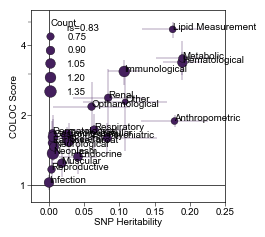

In [165]:
plt_df_hr, r = get_mean_and_sem_per_domain(best_h2, 'SNP-Heritability', 'SizeOE')
ax = plot_domain_scatter(plt_df_hr, 'SNP-Heritability_mean', 'log2SizeOE', color=purple, annotate=True)
ax.hlines(y=0, xmin=-0.025, xmax=0.25, color='black', linewidth=0.5, zorder=1)
ax.vlines(x=0, ymin=-0.25, ymax=2.5, color='black', linewidth=0.5, zorder=2)
ax.set_xlim(-0.025,0.25)
ax.set_yticks([-1, 0, 1, 2,], labels=[0.5, 1, 2, 4])
_ = ax.set_yticks(np.log2([3,5, 6,]), minor=True)
ax.set_ylim(-0.25,2.5)
ax.set_ylabel('COLOC Score')
ax.set_xlabel('SNP Heritability')
ax.text(0.025, 2.2, s=f'rs={r:.2f}')

0.3077922077922078


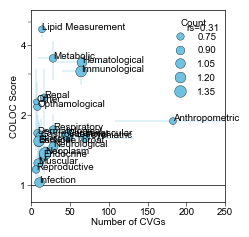

In [166]:
plt_df_c, r = get_mean_and_sem_per_domain(best_h2, 'nCommon', 'SizeOE')
ax = plot_domain_scatter(plt_df_c, 'nCommon_mean', 'log2SizeOE', color=blue, annotate=True)
ax.hlines(y=0, xmin=-1, xmax=250, color='black', linewidth=0.5, zorder=1)
ax.set_yticks([-1, 0, 1, 2,], labels=[0.5, 1, 2, 4])
_ = ax.set_yticks(np.log2([3,5, 6,]), minor=True)
ax.set_ylim(-0.25,2.5)
ax.set_xlim(0, 250)
ax.set_ylabel('COLOC Score')
ax.set_xlabel('Number of CVGs')
ax.text(200, 2.2, s=f'rs={r:.2f}')
print(r)

0.35324675324675325


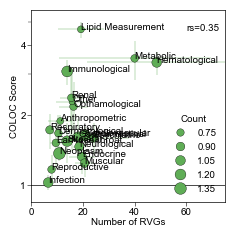

In [167]:
plt_df_c, r = get_mean_and_sem_per_domain(best_h2, 'nRare', 'SizeOE')
ax = plot_domain_scatter(plt_df_c, 'nRare_mean', 'log2SizeOE', color=green, annotate=True)
ax.hlines(y=0, xmin=-1, xmax=75, color='black', linewidth=0.5, zorder=1)
ax.set_yticks([-1, 0, 1, 2,], labels=[0.5, 1, 2, 4])
_ = ax.set_yticks(np.log2([3,5, 6,]), minor=True)
ax.set_ylim(-0.25,2.5)
ax.set_xlim(0, 75)
ax.set_ylabel('COLOC Score')
ax.set_xlabel('Number of RVGs')
ax.text(60, 2.2, s=f'rs={r:.2f}')
print(r)

### SFigure 3B - Gene count analysis

In [168]:
all_feat_plot = all_feat[all_feat.trait_pair.isin(best_df.trait_pair.values)].copy()

In [169]:
def get_shared_genes(nc, nr, j):
    return int((nc+nr)/(1 + 1/j))

In [170]:
all_feat_plot['nShared'] = all_feat_plot.apply(lambda z: 0 if z.J_RC==0 else get_shared_genes(z.g_C, z.g_R, z.J_RC), axis=1)
all_feat['nShared'] = all_feat.apply(lambda z: 0 if z.J_RC==0 else get_shared_genes(z.g_C, z.g_R, z.J_RC), axis=1)

In [171]:
# total is incorrect without number of shared genes.
all_feat_plot['g_Total'] = all_feat_plot.g_C + all_feat_plot.g_R - all_feat_plot.nShared
all_feat['g_Total'] = all_feat.g_C + all_feat.g_R - all_feat.nShared

In [172]:
r_g_best = all_feat_plot.corr(method='spearman', numeric_only=True).loc[[ 'g_R', 'g_C', 'g_Total']].Log2SizeOE
r_g = all_feat.corr(method='spearman', numeric_only=True).loc[[ 'g_R', 'g_C', 'g_Total']].Log2SizeOE

(-0.5, 9.5)

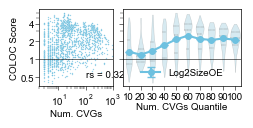

In [174]:
_, [ax2, ax1] = plt.subplots(nrows=1, ncols=2, figsize=(2.6,1), gridspec_kw={'wspace':0.1}, sharey=True,
                            width_ratios=(1,1.6))


sns.scatterplot(all_feat, y='Log2SizeOE', x='g_C', alpha=0.7, color=blue, s=1, ax=ax2)
ax2.hlines(y=0, xmin=2, xmax=1050, color='black', linewidth=0.4)

ax2.set_yticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
_ = ax2.set_yticks(np.log2([3,5,6]), minor=True)
_ =ax2.set_ylabel('COLOC Score')
_ =ax2.set_xlabel('Num. CVGs')
_ = ax2.text(x=100, y=-1, s=f'rs = {r_g["g_C"]:.2f}')
ax2.set_xscale('log')
ax2.set_xlim(2, 1050)

a, am = plot_feature_means_by_y_quantile_lines(
     all_feat.drop(columns=['g_C']),
     all_feat.drop(columns=[]),
    
    y_col='g_C',
     n_quantiles=10,
     feature_name_map=feature_names,
     subset_features=['Log2SizeOE'],
        figsize=(2.5,1.5),
        colors=[blue],
        ax=ax1,
    markersize=4,
    plot_violin=False
 )

sns.violinplot(am, x='bin', y='value', fill=True, inner='quart', 
               alpha=0.3, color=blue, zorder=0, ax=ax1, cut=0, linewidth=0.3)
ax1.set_ylabel('')
ax1.set_xlabel('Num. CVGs Quantile')

ax1.set_yticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
_ = ax1.set_yticks(np.log2([3,5,6]), minor=True)
ax1.hlines(y=0, xmin=-2, xmax=10, color='black', linewidth=0.4)
ax1.set_xlim(-0.5, 9.5)

(-0.5, 9.5)

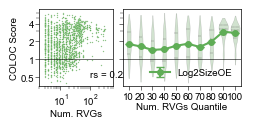

In [175]:
_, [ax2, ax1] = plt.subplots(nrows=1, ncols=2, figsize=(2.6,1), gridspec_kw={'wspace':0.1}, sharey=True,
                            width_ratios=(1,1.6))


sns.scatterplot(all_feat, y='Log2SizeOE', x='g_R', alpha=0.7, color=green, s=1, ax=ax2)
ax2.hlines(y=0, xmin=2, xmax=1050, color='black', linewidth=0.4)

ax2.set_yticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
_ = ax2.set_yticks(np.log2([3,5,6]), minor=True)
_ =ax2.set_ylabel('COLOC Score')
_ =ax2.set_xlabel('Num. RVGs')
_ = ax2.text(x=100, y=-1, s=f'rs = {r_g["g_R"]:.2f}')
ax2.set_xscale('log')
ax2.set_xlim(2, 600)

a, am = plot_feature_means_by_y_quantile_lines(
     all_feat.drop(columns=['g_R']),
     all_feat.drop(columns=[]),
    
    y_col='g_R',
     n_quantiles=10,
     feature_name_map=feature_names,
     subset_features=['Log2SizeOE'],
        figsize=(2.5,1.5),
        colors=[green],
        ax=ax1,
    markersize=4,
    plot_violin=False
 )

sns.violinplot(am, x='bin', y='value', fill=True, inner='quart', 
               alpha=0.3, color=green, zorder=0, ax=ax1, cut=0, linewidth=0.3)
ax1.set_ylabel('')
ax1.set_xlabel('Num. RVGs Quantile')

ax1.set_yticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
_ = ax1.set_yticks(np.log2([3,5,6]), minor=True)
ax1.hlines(y=0, xmin=-2, xmax=10, color='black', linewidth=0.4)
ax1.set_xlim(-0.5, 9.5)

(-0.5, 9.5)

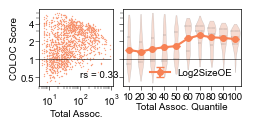

In [176]:
_, [ax2, ax1] = plt.subplots(nrows=1, ncols=2, figsize=(2.6,1), gridspec_kw={'wspace':0.1}, sharey=True,
                            width_ratios=(1,1.6))


sns.scatterplot(all_feat, y='Log2SizeOE', x='g_Total', alpha=0.7, color='#F78154', s=1, ax=ax2)
ax2.hlines(y=0, xmin=2, xmax=1050, color='black', linewidth=0.4)

ax2.set_yticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
_ = ax2.set_yticks(np.log2([3,5,6]), minor=True)
_ =ax2.set_ylabel('COLOC Score')
_ =ax2.set_xlabel('Total Assoc.')
_ = ax2.text(x=100, y=-1, s=f'rs = {r_g["g_Total"]:.2f}')
ax2.set_xscale('log')
ax2.set_xlim(5, 1200)

a, am = plot_feature_means_by_y_quantile_lines(
     all_feat.drop(columns=['g_Total']),
     all_feat.drop(columns=[]),
    
    y_col='g_Total',
     n_quantiles=10,
     feature_name_map=feature_names,
     subset_features=['Log2SizeOE'],
        figsize=(2.5,1.5),
        colors=['#F78154'],
        ax=ax1,
    markersize=4,
    plot_violin=False
 )

sns.violinplot(am, x='bin', y='value', fill=True, inner='quart', 
               alpha=0.3, color='#F78154', zorder=0, ax=ax1, cut=0, linewidth=0.3)
ax1.set_ylabel('')
ax1.set_xlabel('Total Assoc. Quantile')

ax1.set_yticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
_ = ax1.set_yticks(np.log2([3,5,6]), minor=True)
ax1.hlines(y=0, xmin=-2, xmax=10, color='black', linewidth=0.4)
ax1.set_xlim(-0.5, 9.5)

### Figure 4C - Heritability Correlations

In [177]:
h2_corrs = {}
for prop in ['J_RC', 'assortativity_RC', 'density_R', 'g_C', 'DiffRC_GeneSize', 
            'N_R', 'Mean_GO', 'DiffRC_GO', 'N_C', 'DiffRC_Constraint', 'g_R', 'density_C', 'Mean_nTissues',
            'Mean_mRNA', 'Mean_Constraint', 'DiffRC_mRNA', 'Mean_GeneSize', 'DiffRC_nTissues']:
    h2_corrs[prop] = {}
    h2_corrs[prop]['r'] = spearmanr(all_feat_h2['SNP-Heritability'], all_feat_h2[prop]).statistic
    h2_corrs[prop]['p'] = spearmanr(all_feat_h2['SNP-Heritability'], all_feat_h2[prop]).pvalue
h2_corrs = pd.DataFrame(h2_corrs).T
h2_corrs['q'] = fdrcorrection(h2_corrs.p.values)[1]
h2_corrs['logq'] = h2_corrs.q.apply(lambda x: 'n.s' if x >0.05 else 'q < 0.05' if x > 0.0001 else 'q < 10-4' if x > 0.00000001 else 'q < 10-8')
h2_corrs['Property'] = h2_corrs.index.map(feature_names)

Text(0.5, 0, 'SNP Heritability\nSpearman Correlation')

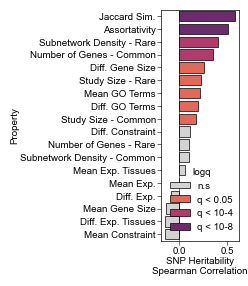

In [178]:
_ = plt.figure(figsize=(1,3))
sns.barplot(h2_corrs.sort_values(by='r', ascending=False), y='Property', x='r',  hue='logq', edgecolor='black', saturation=1, 
            palette=['lightgrey', '#e3685c', '#b13c6c', '#6c2b6d'], 
            hue_order = ['n.s', 'q < 0.05', 'q < 10-4', 'q < 10-8'])
plt.vlines(x=0, ymin=-0.5, ymax=17.5, color='black', linewidth=0.4)
plt.ylim(17.5, -0.5)
plt.xlabel('SNP Heritability\nSpearman Correlation')

## Regression Analysis

### Normalization & Scaling

In [179]:
def compare_transforms(input_df, col, log=False):
    _, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(nrows=5, ncols=1, figsize=(5, 6))
    if log:
        X = np.log10(input_df[col].values).reshape(-1,1)
    else:
        X = input_df[col].values.reshape(-1,1)
    transformer1 = prep.QuantileTransformer(n_quantiles=len(X)).fit(X)
    transformer4 = prep.QuantileTransformer(output_distribution='normal', n_quantiles=len(X)).fit(X)
    transformer2 = prep.RobustScaler().fit(X)
    transformer3 = prep.PowerTransformer().fit(X)
    sns.histplot(X, ax=ax1)
    sns.histplot(transformer1.transform(X), ax=ax2)
    sns.histplot(transformer4.transform(X), ax=ax3)
    sns.histplot(transformer2.transform(X), ax=ax4)
    sns.histplot(transformer3.transform(X), ax=ax5)
    for i, trans in enumerate(['Input', 'Quant-Uni', 'Quant-Norm', 'Robust', 'Power']):
        [ax1, ax2, ax3, ax4, ax5][i].set_ylabel(trans)

In [180]:
# assign transforms
quant_norm= ['N_C', 'N_R', 'assortativity_RC', 'Mean_Constraint', 'DiffRC_Constraint', 'DiffRC_GeneSize', 'DiffRC_nTissues', 
            'Mean_mRNA', 'DiffRC_mRNA',  'Mean_GeneSize', 'Mean_GO', 'DiffRC_GO']
log_robust=[]
power = ['density_R', 'density_C',
        'Mean_nTissues', 'g_C', 'g_R', 'J_RC']
none = ['binary', 'jaccard_zero']

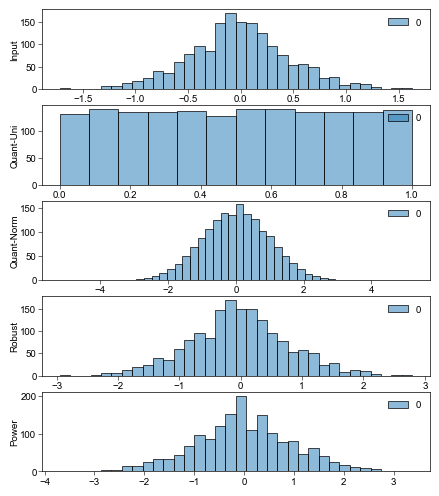

In [181]:
compare_transforms(all_feat, 'DiffRC_GO', log=False)

#### Transform features

In [182]:
all_x = []
x_qn = np.array(all_feat[quant_norm])
transformerqn = prep.QuantileTransformer(n_quantiles=len(x_qn), output_distribution='normal').fit(x_qn)
all_x.append(transformerqn.transform(x_qn))

x_power = np.array(all_feat[power])
transformerp = prep.PowerTransformer().fit(x_power)
all_x.append(transformerp.transform(x_power))

all_x.append(np.array(all_feat[none]))

X = np.concatenate(all_x, axis=1)


In [183]:
scaler2 = prep.StandardScaler().fit(X)
X_scaled2 = scaler2.transform(X)
X3 = sm.add_constant(X_scaled2)

In [184]:
X_df = pd.DataFrame(X_scaled2, columns=quant_norm+power+none)
X_df.index = all_feat.index

#### Transfrorm Target

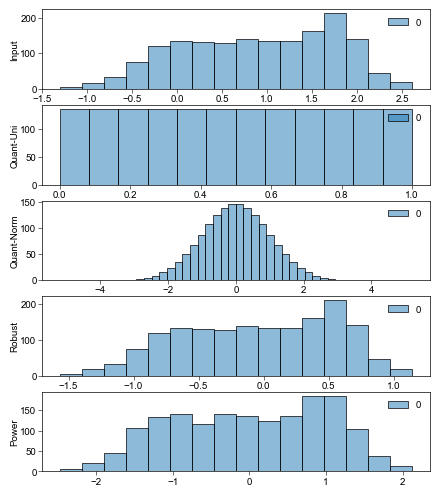

In [185]:
compare_transforms(all_feat, 'Log2SizeOE', log=False)

In [186]:
y = all_feat.Log2SizeOE.values.reshape(-1,1)
transformery = prep.QuantileTransformer(n_quantiles=len(y)).fit(y)
ynorm = transformery.transform(all_feat.Log2SizeOE.values.reshape(-1,1))

In [187]:
y.shape

(1634, 1)

In [188]:
# identify any NA values
all_feat.isna().sum().sum()

0

### Cross-validation

In [189]:
feature_list = quant_norm + log_robust + power +none

In [190]:
def do_cv(X, y, feature_list):
    alphas = np.logspace(-5, 1, 20)
    cv = KFold(n_splits=5, shuffle=True, random_state=1984)
    enet_cv = ElasticNetCV(
        l1_ratio=[.1,.25, .4, .5, .6, .7, .8,  .9, .95, .99, 1],
        alphas=alphas,
        cv=cv,
        max_iter=1000,
        random_state=10,
        fit_intercept=True
    )

    enet_cv.fit(X[:, 1:], y.squeeze())
    print(f"Optimal alpha: {enet_cv.alpha_:.4f}")
    print(f"Optimal l1_ratio: {enet_cv.l1_ratio_:.4f}")
    print("Coefficients:", enet_cv.coef_)
    print("Intercept:", enet_cv.intercept_)
    y_pred = enet_cv.predict(X[:, 1:])
    print("Train MSE:", mean_squared_error(y.squeeze(), y_pred))
    print("Train R²:",  r2_score(y.squeeze(), y_pred))
    print("Coefficients:", [x for x in zip([feature_list+['intercept'], enet_cv.coef_])])
    return enet_cv

In [191]:
enet_cv2 = do_cv(X3, ynorm, feature_list)

Optimal alpha: 0.0144
Optimal l1_ratio: 0.2500
Coefficients: [ 0.         -0.00427101  0.03840687 -0.01151259  0.          0.01222153
 -0.00729656 -0.          0.          0.         -0.          0.00177187
  0.03643895  0.00921355 -0.          0.00384048 -0.00036895  0.11880857
 -0.03563493 -0.05162857]
Intercept: 0.49999999999999994
Train MSE: 0.01964807880207577
Train R²: 0.7645114665409928
Coefficients: [(['N_C', 'N_R', 'assortativity_RC', 'Mean_Constraint', 'DiffRC_Constraint', 'DiffRC_GeneSize', 'DiffRC_nTissues', 'Mean_mRNA', 'DiffRC_mRNA', 'Mean_GeneSize', 'Mean_GO', 'DiffRC_GO', 'density_R', 'density_C', 'Mean_nTissues', 'g_C', 'g_R', 'J_RC', 'binary', 'jaccard_zero', 'intercept'],), (array([ 0.        , -0.00427101,  0.03840687, -0.01151259,  0.        ,
        0.01222153, -0.00729656, -0.        ,  0.        ,  0.        ,
       -0.        ,  0.00177187,  0.03643895,  0.00921355, -0.        ,
        0.00384048, -0.00036895,  0.11880857, -0.03563493, -0.05162857]),)]


In [192]:
best_alpha = enet_cv2.alpha_
best_l1=  enet_cv2.l1_ratio_
print('Best Alpha', best_alpha)
print('Best L1 Ratio', best_l1)

Best Alpha 0.01438449888287663
Best L1 Ratio 0.25


In [193]:
pd.DataFrame(X3,columns=feature_list+['intercept'], index=all_feat.index.values).N_R.describe()

count    1.634000e+03
mean     1.848107e-17
std      1.000306e+00
min     -5.114161e+00
25%     -6.618294e-01
50%      2.062339e-03
75%      6.656286e-01
max      5.116775e+00
Name: N_R, dtype: float64

In [194]:
y_pred = enet_cv2.predict(X3[:,1:])

print("Train MSE:", mean_squared_error(ynorm.squeeze(), y_pred))
print("Train R²:",  r2_score(ynorm.squeeze(), y_pred))
print("Variance Explained:",  explained_variance_score(ynorm.squeeze(), y_pred))


Train MSE: 0.01964807880207577
Train R²: 0.7645114665409928
Variance Explained: 0.7645114665409928


Text(0, 0.5, 'Predicted values')

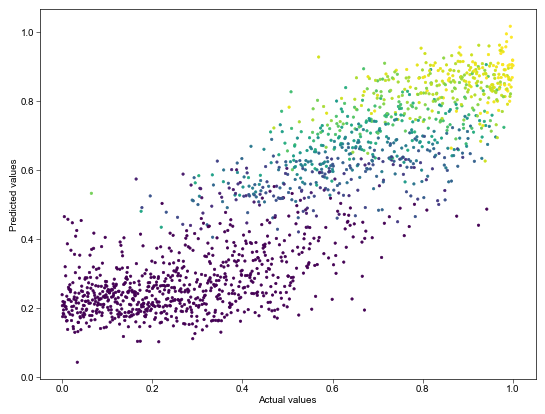

In [195]:
plt.scatter(ynorm, y_pred, s=3,c=X3[:, -3])
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

### Bootstrapping

In [196]:
B = 2000
coefs = np.zeros((B, X3[:, 1:].shape[1]))
r2 = []
intercepts = []

for b in range(B):
    # sample with replacement
    idx = np.random.choice(len(ynorm), len(ynorm), replace=True)
    Xb, yb = X3[:, 1:][idx], ynorm[idx]

    # refit final model
    model = ElasticNet(
        alpha=best_alpha,
        l1_ratio=best_l1,
        max_iter=1000,
        random_state=b
    ).fit(Xb, yb)

    coefs[b, :] = model.coef_
    yp = model.predict(Xb)
    r2.append( r2_score(yb.squeeze(), yp))
    intercepts.append(model.intercept_)
# compute bootstrap SEs
se = coefs.std(axis=0)
print("Coefficient SEs:", se)


Coefficient SEs: [0.00146288 0.00330215 0.00533968 0.00504589 0.00235907 0.00417045
 0.00402578 0.00176994 0.00172298 0.00174187 0.00251029 0.00295063
 0.0048542  0.00449982 0.00149801 0.00423042 0.00265658 0.0068018
 0.0055978  0.00744455]


In [197]:

bootstrap_means = coefs.mean(axis=0)
bootstrap_sds   = coefs.std(axis=0, ddof=1) # ddof=1 for sample‐std

# print mean ± SE
for j, (m, se) in enumerate(zip(bootstrap_means, bootstrap_sds)):
    print(f"β_{j}: {m:.4f} \u00B1 {se:.4f}")

print(f"R2: {np.mean(r2):.3f} \u00B1 {np.std(r2):.4f}")
print(f"Intercept: {np.mean(intercepts):.3f} \u00B1 {np.std(intercepts):.4f}")

β_0: 0.0005 ± 0.0015
β_1: -0.0041 ± 0.0033
β_2: 0.0388 ± 0.0053
β_3: -0.0113 ± 0.0050
β_4: 0.0016 ± 0.0024
β_5: 0.0121 ± 0.0042
β_6: -0.0079 ± 0.0040
β_7: -0.0008 ± 0.0018
β_8: 0.0006 ± 0.0017
β_9: 0.0005 ± 0.0017
β_10: -0.0016 ± 0.0025
β_11: 0.0024 ± 0.0030
β_12: 0.0364 ± 0.0049
β_13: 0.0096 ± 0.0045
β_14: -0.0005 ± 0.0015
β_15: 0.0041 ± 0.0042
β_16: -0.0018 ± 0.0027
β_17: 0.1198 ± 0.0068
β_18: -0.0356 ± 0.0056
β_19: -0.0513 ± 0.0074
R2: 0.768 ± 0.0094
Intercept: 0.500 ± 0.0034


In [198]:
lower_pct, upper_pct = 2.5, 97.5

# Compute the percentiles
ci_lower = np.percentile(coefs, lower_pct, axis=0)
ci_upper = np.percentile(coefs, upper_pct, axis=0)

for j, (low, high) in enumerate(zip(ci_lower, ci_upper)):
    print(f"β_{feature_list[j]} 95% CI (percentile): [{low:.4f}, {high:.4f}]")


β_N_C 95% CI (percentile): [-0.0012, 0.0049]
β_N_R 95% CI (percentile): [-0.0112, 0.0000]
β_assortativity_RC 95% CI (percentile): [0.0284, 0.0491]
β_Mean_Constraint 95% CI (percentile): [-0.0215, -0.0014]
β_DiffRC_Constraint 95% CI (percentile): [0.0000, 0.0077]
β_DiffRC_GeneSize 95% CI (percentile): [0.0041, 0.0204]
β_DiffRC_nTissues 95% CI (percentile): [-0.0158, 0.0000]
β_Mean_mRNA 95% CI (percentile): [-0.0062, 0.0004]
β_DiffRC_mRNA 95% CI (percentile): [-0.0001, 0.0059]
β_Mean_GeneSize 95% CI (percentile): [-0.0015, 0.0056]
β_Mean_GO 95% CI (percentile): [-0.0084, 0.0000]
β_DiffRC_GO 95% CI (percentile): [0.0000, 0.0100]
β_density_R 95% CI (percentile): [0.0268, 0.0458]
β_density_C 95% CI (percentile): [0.0009, 0.0185]
β_Mean_nTissues 95% CI (percentile): [-0.0050, 0.0004]
β_g_C 95% CI (percentile): [0.0000, 0.0140]
β_g_R 95% CI (percentile): [-0.0092, 0.0000]
β_J_RC 95% CI (percentile): [0.1070, 0.1330]
β_binary 95% CI (percentile): [-0.0461, -0.0242]
β_jaccard_zero 95% CI (perce

In [199]:

B, n_features = coefs.shape
pvals = np.zeros(n_features)
for j in range(n_features):
    # fraction of bootstraps ≤ 0 and ≥ 0
    if np.sum(coefs[:, j] < 0) + np.sum(coefs[:, j] > 0) > 0:
        frac_le = (np.sum(coefs[:, j] < 0) + 1)/(B+1)
        frac_ge = (np.sum(coefs[:, j] > 0) + 1)/(B+1) 
        # two-sided q-value
        pvals[j] = min(1, 2 * min(frac_le, frac_ge)*n_features)
    else:
        pvals[j] = np.nan
for j, p in enumerate(pvals):
    print(f"coef #{feature_list[j]}: p ≈ {p:.8f}")


coef #N_C: p ≈ 1.00000000
coef #N_R: p ≈ 0.05997001
coef #assortativity_RC: p ≈ 0.01999000
coef #Mean_Constraint: p ≈ 0.01999000
coef #DiffRC_Constraint: p ≈ 0.49975012
coef #DiffRC_GeneSize: p ≈ 0.01999000
coef #DiffRC_nTissues: p ≈ 0.01999000
coef #Mean_mRNA: p ≈ 1.00000000
coef #DiffRC_mRNA: p ≈ 1.00000000
coef #Mean_GeneSize: p ≈ 1.00000000
coef #Mean_GO: p ≈ 0.69965017
coef #DiffRC_GO: p ≈ 0.17991004
coef #density_R: p ≈ 0.01999000
coef #density_C: p ≈ 0.01999000
coef #Mean_nTissues: p ≈ 1.00000000
coef #g_C: p ≈ 0.01999000
coef #g_R: p ≈ 0.29985007
coef #J_RC: p ≈ 0.01999000
coef #binary: p ≈ 0.01999000
coef #jaccard_zero: p ≈ 0.01999000


### Table 1

In [201]:

coef_df = pd.DataFrame({
    'Feature': feature_list,
    'Coefficient': bootstrap_means,
    'CI Lower': ci_lower,
    'CI Upper': ci_upper,
    'P-Val': pvals
})

coef_df['95% CI'] = coef_df.apply(
    lambda row: f"({row['CI Lower']:.3f}, {row['CI Upper']:.3f})", axis=1)

order = [feature_names[x] for x in ['g_C', 'g_R', 'density_C', 'density_R', 'N_C', 'N_R', 
         'Mean_Constraint', 'DiffRC_Constraint', 'Mean_GeneSize', 'DiffRC_GeneSize', 'Mean_nTissues', 'DiffRC_nTissues',
         'Mean_mRNA', 'DiffRC_mRNA', 'Mean_GO', 'DiffRC_GO',
         'jaccard_zero',
        'J_RC', 'assortativity_RC', 'binary']]
coef_df['Feature'] = coef_df['Feature'].map(feature_names)
coef_df.set_index('Feature').loc[order, ( 'Coefficient', '95% CI', 'P-Val')].to_csv(os.path.join(datadir, 'elastic_net_coefs4_2000_test.tsv'), sep='\t')



In [202]:
coef_df

,Feature,Coefficient,CI Lower,CI Upper,P-Val,95% CI
0,Study Size - Common,0.000495,-0.001174,0.004909,1.00000,"(-0.001, 0.005)"
1,Study Size - Rare,-0.004121,-0.011224,0.000000,0.05997,"(-0.011, 0.000)"
2,Assortativity,0.038759,0.028413,0.049061,0.01999,"(0.028, 0.049)"
3,Mean Constraint,-0.011321,-0.021546,-0.001351,0.01999,"(-0.022, -0.001)"
4,Diff. Constraint,0.001573,0.000000,0.007657,0.49975,"(0.000, 0.008)"
5,Diff. Gene Size,0.012122,0.004052,0.020403,0.01999,"(0.004, 0.020)"
6,Diff. Exp. Tissues,-0.007921,-0.015815,0.000000,0.01999,"(-0.016, 0.000)"
7,Mean Exp.,-0.000821,-0.006186,0.000421,1.00000,"(-0.006, 0.000)"
8,Diff. Exp.,0.000608,-0.000143,0.005947,1.00000,"(-0.000, 0.006)"
9,Mean Gene Size,0.000454,-0.001542,0.005587,1.00000,"(-0.002, 0.006)"


### Residuals calculation

In [203]:
residuals = np.subtract(ynorm.squeeze(), y_pred.squeeze())

In [204]:
resid_df = pd.DataFrame({'Log2SizeOE_norm':ynorm.squeeze(), 'Log2SizeOE':y.squeeze(), 'Prediction':y_pred, 'Residual':residuals}, index=all_feat.trait_pair.values)

In [205]:
resid_df.to_csv(os.path.join(datadir, 'outputs/residuals_mod4.tsv'), sep='\t')

In [206]:
resid_df = pd.read_csv(os.path.join(datadir, 'outputs/residuals_mod4.tsv'), sep='\t', index_col=0)

### SFigure 4C - Residual Heritability

In [207]:
all_feat_h2 = all_feat_h2.drop(columns=['Log2SizeOE']).merge(resid_df.reset_index(names=['trait_pair']), on='trait_pair', how='left')

In [208]:
r_h2_res = all_feat_h2.loc[:, ('Log2SizeOE', 'Residual', 'SNP-Heritability')].corr(method='spearman').at['Residual', 'SNP-Heritability']

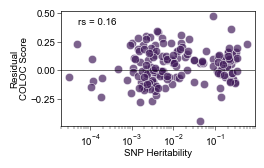

In [210]:
_ = plt.figure(figsize=(2.5,1.5))
#sns.scatterplot(all_feat_h2, y='Log2SizeOE', x='h2_observed', alpha=0.7, color='grey')
sns.scatterplot(all_feat_h2, y='Residual', x='SNP-Heritability', alpha=0.7, color=purple)
plt.hlines(y=0, xmin=-0.05, xmax=0.9, color='black', linewidth=0.4)
#plt.hlines(y=[np.log2(1.3), np.log2(2.5)], xmin=-0.05, xmax=0.9, color='black', linewidth=0.4, linestyle='--')
plt.xlim(0.00002, 0.9)
ax1 = plt.gca()
#ax1.set_yticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
#_ = ax1.set_yticks(np.log2([3,5,6]), minor=True)
_ =ax1.set_ylabel('Residual\nCOLOC Score')
_ =ax1.set_xlabel('SNP Heritability')
_ = plt.text(x=0.00005, y=0.4, s=f'rs = {r_h2_res:.2f}')
plt.xscale('log')

## Feature examination

### Figure 4D - Trait type and shared genes

In [212]:
def plot_fraction_by_y_quantile_bars(
    X_df: pd.DataFrame,
    y_df: pd.DataFrame,
    y_col: str,
    group_col: str = None,
    group_order: list = None,
    n_quantiles: int = 10,
    subset_features: list = None,
    feature_name_map: dict = None,
    figsize: tuple = (10, 6),
    colors: list = None,
    ax: plt.Axes = None,
    plot_violin=False
):
    """
    Plot feature means ± SEM across either y-quantile bins or predefined groups.

    Parameters
    ----------
    X_df : pd.DataFrame
        Feature DataFrame (n_samples x n_features).
    y_df : pd.DataFrame
        DataFrame containing the target column and optional group column.
    y_col : str
        Name of the column in y_df to use as the continuous target (for quantiles).
    group_col : str, optional
        Name of the column in y_df to use as categorical grouping. If provided,
        samples are grouped by this column instead of quantiles.
    group_order : list of str, optional
        Desired order of categories in group_col. Categories not present are dropped.
    n_quantiles : int, default=10
        Number of equal-sized bins to cut y into (used only if group_col is None).
    subset_features : list of str, optional
        Names of features in X_df to plot. If None, all columns of X_df are used.
    feature_name_map : dict, optional
        Mapping from X_df column names to display names for plotting.
    figsize : tuple, optional
        Matplotlib figure size.
    colors : list of str, optional
        List of colors for each feature line.
    ax : matplotlib.axes.Axes, optional
        Axes object to draw on; if None, a new figure and axes are created.
    """
    # Join X and y on index
    merged = X_df.join(y_df[[y_col] + ([group_col] if group_col else [])], how='inner')

    # Select features
    all_features = X_df.columns.tolist()
    features_to_plot = subset_features if subset_features else all_features
    X = merged[features_to_plot].values

    # Determine grouping or quantiles
    if group_col:
        _ = plt.figure(figsize=(2,1.5))
        class_counts = all_feat[group_col].value_counts().to_dict()
        plot_df = (1- all_feat.groupby(group_col)[subset_features].mean()).melt(ignore_index=False).reset_index()
        order=['Negative','None', 'Weak', 'Moderate', 'Strong']
        sns.barplot(plot_df, order=order,
                    x=group_col, y='value', hue='variable',
                   palette=colors, saturation=1, edgecolor='black')

        plt.xticks([i for i in range(5)], labels=[f'{x}\n(n={class_counts[x]})' for x in order])
        plt.tick_params(axis='x', rotation=90)
    else:
        y = merged[y_col].values
        try:
            bins = pd.qcut(y, q=n_quantiles, labels=False, duplicates='drop')
        except ValueError:
            rank = np.argsort(np.argsort(y))
            bins = np.floor((rank / len(y)) * n_quantiles).astype(int)
            bins[bins == n_quantiles] = n_quantiles - 1
        unique_bins = np.unique(bins)
        labels = [f"{(i+1)*10}" for i in unique_bins]
        n_bins = len(unique_bins)

        # Compute per-bin means and SEM
        means = np.zeros((n_bins, X.shape[1]))
        x = np.arange(n_bins)
        for i in range(n_bins):
            vals = X[bins == i]
            means[i] = vals.mean(axis=0)
        plot_df = pd.DataFrame(means, columns=subset_features).melt(ignore_index=False).reset_index()

        # Create axes if needed
        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)
            sns.barplot(plot_df, x='index', y='value', hue='variable', palette=colors, order=x, ax=ax,
                       saturation=1, edgecolor='black')
            ax.set_xticks(x, labels)
    # Plot each feature line
    
  

In [213]:
all_feat = all_feat.set_index('trait_pair')
all_feat.index.name=''

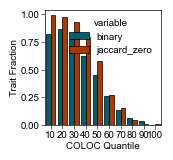

In [214]:
plot_fraction_by_y_quantile_bars(
     all_feat.drop(columns=['Log2SizeOE']),
     resid_df,
    y_col='Log2SizeOE',
     n_quantiles=10,
     feature_name_map=feature_names,
     subset_features=['binary', 'jaccard_zero'],
        figsize=(1.5,1.5),
        colors=[binary, shared],
        ax=None
 )
_ = plt.ylabel('Trait Fraction')
_ = plt.xlabel('COLOC Quantile')

### Figure 4E - network features

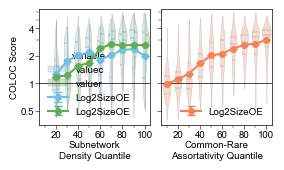

In [216]:
_, [ax1,ax2] = plt.subplots(ncols=2, nrows=1, figsize=(3, 1.5), sharey=True, gridspec_kw={'wspace':0.1})
a, am = plot_feature_means_by_y_quantile_lines(
     resid_df,
     all_feat.drop(columns=[]),
    
    y_col='density_C',
     n_quantiles=10,
     feature_name_map=feature_names,
     subset_features=['Log2SizeOE'],
        figsize=(2.5,1.5),
        colors=[blue],
        ax=ax1,
    markersize=4,
    plot_violin=False
 )
b, bm = plot_feature_means_by_y_quantile_lines(
    resid_df,
     all_feat.drop(columns=[]),
     
    y_col='density_R',
     n_quantiles=10,
     feature_name_map=feature_names,
     subset_features=['Log2SizeOE'],
        figsize=(2.5,1.5),
        colors=[green],
        ax=ax1,
    markersize=4
 )
ax1.set_xticks([0,2,4,6,8], labels=[20,40,60,80,100])
_= ax1.set_xticks([-1, 1,3,5,7], minor=True)


c, cm = plot_feature_means_by_y_quantile_lines(
     resid_df,
     all_feat.drop(columns=[]),
    
    y_col='assortativity_RC',
     n_quantiles=10,
     feature_name_map=feature_names,
     subset_features=['Log2SizeOE'],
        figsize=(2.5,1.5),
        colors=['#F78154'],
        ax=ax2, 
    markersize=4
 )
ax1.set_xlabel('Subnetwork\nDensity Quantile')
ax2.set_xlabel('Common-Rare\nAssortativity Quantile')
ax2.set_xticks([1,3,5,7,9], labels=[20,40,60,80,100])
_= ax2.set_xticks([0, 2,4,6,8], minor=True)

am = am.sort_values('bin').reset_index(drop=True)
bm = bm.sort_values('bin').reset_index(drop=True)
all_m = am.join(bm, lsuffix='c', rsuffix='r').melt(id_vars='binc', value_vars=['valuec', 'valuer'])
sns.violinplot(all_m, x='binc', y='value', hue='variable', split=True, fill=True, inner='quart', 
               alpha=0.3, palette=[blue, green], zorder=0, ax=ax1, cut=0, linewidth=0.3)

sns.violinplot(cm, x='bin', y='value', fill=True, inner='quart', 
               alpha=0.3, color='#F78154', zorder=0, ax=ax2, cut=0, linewidth=0.3)

for ax in [ax1, ax2]:
    ax.set_ylim(-1.5, 2.7)
    
    ax.hlines(y=0, xmin=-2, xmax=10, color='black', linewidth=0.5)
ax1.set_xlim(-1.5, 8.5)
ax2.set_xlim(-0.5, 9.5)
ax1.set_ylabel('COLOC Score')
ax2.set_ylabel('')
ax1.set_yticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
_ = ax1.set_yticks(np.log2([3,5,6]), minor=True)


### Figure 4F - biological features

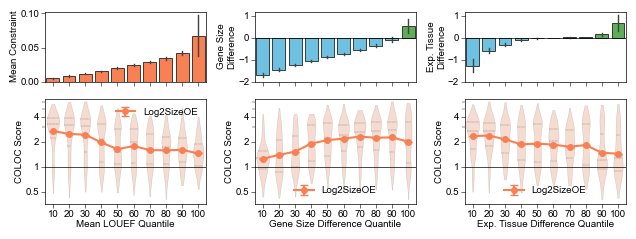

In [218]:
_, [[ax4,ax5,ax6],[ax1, ax2, ax3]] = plt.subplots(ncols=3, nrows=2, figsize=(7.5, 2.5), sharey=False, sharex='col',
                                                  gridspec_kw={'hspace':0.2, 'wspace':0.3,
                                 'height_ratios':[2,3]})

a, am = plot_feature_means_by_y_quantile_lines(
    resid_df,
     all_feat.drop(columns=[]),
     
    y_col='Mean_Constraint',
     n_quantiles=10,
     feature_name_map=feature_names,
     subset_features=['Log2SizeOE'],
        figsize=(2,1.5),
        colors=['#F78154'],
        ax=ax1,
    markersize=4
 )

sns.violinplot(am, x='bin', y='value', fill=True, inner='quart', 
               alpha=0.3, color='#F78154', zorder=0, ax=ax1, cut=0, linewidth=0.3)
ax1.set_ylabel('COLOC Score')
ax1.set_xlabel('Mean LOUEF Quantile')
sns.barplot(a, x='bin', y='y', ax=ax4,errorbar='sd', err_kws={'linewidth':1}, color='#F78154',
           edgecolor='black', saturation=1)
ax4.set_ylabel('Mean Constraint')

b, bm = plot_feature_means_by_y_quantile_lines(
    resid_df,
     all_feat.drop(columns=[]),
     
    y_col='DiffRC_GeneSize',
     n_quantiles=10,
     feature_name_map=feature_names,
     subset_features=['Log2SizeOE'],
        figsize=(2,1.5),
        colors=['#F78154'],
        ax=ax2,
    markersize=4
 )
bb = b.groupby('bin').y.mean().reset_index()
bb['color'] = bb.y.apply(lambda x: blue if x <0 else green)
ax2.set_ylabel('COLOC Score')
ax2.set_xlabel('Gene Size Difference Quantile')
sns.violinplot(bm, x='bin', y='value', fill=True, inner='quart', 
               alpha=0.3, color='#F78154', zorder=0, ax=ax2, cut=0, linewidth=0.3)


sns.barplot(b, x='bin', y='y', ax=ax5,errorbar='sd', err_kws={'linewidth':1}, hue='bin', legend=False,
           palette=list(bb.color.values), saturation=1, edgecolor='black')

ax5.set_ylabel('Gene Size\nDifference')
ax5.hlines(y=0, xmin=-0.5, xmax=9.5, color='black', linewidth=0.5)
ax5.set_xlim(-0.5, 9.5)

#_ = ax2.set_xlabel('')
c, cm = plot_feature_means_by_y_quantile_lines(
     resid_df,
     all_feat.drop(columns=[]),
    
    y_col='DiffRC_nTissues',
     n_quantiles=10,
     feature_name_map=feature_names,
     subset_features=['Log2SizeOE'],
        figsize=(2,1.5),
        colors=['#F78154'],
        ax=ax3,
    markersize=4
 )
sns.violinplot(cm, x='bin', y='value', fill=True, inner='quart', 
               alpha=0.3, color='#F78154', zorder=0, ax=ax3, cut=0, linewidth=0.3)
ax3.set_ylabel('COLOC Score')
ax3.set_xlabel('Exp. Tissue Difference Quantile')
cc = c.groupby('bin').y.mean().reset_index()
cc['color'] = cc.y.apply(lambda x: blue if x <0 else green)
sns.barplot(c, x='bin', y='y', ax=ax6, errorbar='sd', err_kws={'linewidth':1}, hue='bin', legend=False,
           palette = list(cc.color.values), saturation=1, edgecolor='black')
ax6.set_ylabel('Exp. Tissue\nDifference')
ax6.hlines(y=0, xmin=-0.5, xmax=9.5, color='black', linewidth=0.5)
ax6.set_xlim(-0.5, 9.5)

for ax in [ax5, ax6]:
    ax.set_ylim(-2, 1.2)
    ax.set_yticks([-2, -1, 0, 1])
for ax in [ax1, ax2, ax3]:
    ax.set_ylim(-1.5, 2.7)
    ax.set_yticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
    _ = ax.set_yticks(np.log2([3,5,6]), minor=True)
    ax.hlines(y=0, xmin=-2, xmax=10, color='black', linewidth=0.5)
    ax.set_xlim(-0.5, 9.5)


## Tissue Specificty

In [219]:
def load_results(file_name, best_df):
    tiss_df = pd.read_csv(os.path.join(datadir, 'outputs', 
                                       file_name), sep='\t')
    tiss_df = tiss_df.assign(Domain=tiss_df.GeneSet.map(best_df.set_index('trait_pair').Domain.to_dict()))
    tiss_df = tiss_df.assign(name=tiss_df.GeneSet.map(best_df.set_index('trait_pair')['Trait'].to_dict()))
    tiss_df['Domain']  = tiss_df.Domain.apply(lambda x: x.lower())
    tiss_df['log2FoldChange'] = np.log2(tiss_df['fold.change'])
    tiss_df['EFO'] = tiss_df.GeneSet.map(best_df.set_index('trait_pair')['EFO'].to_dict())
    return tiss_df


In [220]:
info_df = pd.read_csv(os.path.join(datadir, 'outputs/STable1.tsv'), sep='\t', usecols=['Mapped EFO', 'Trait Type', 
                                                                              'Biological Domain', 'Mapped Trait']).drop_duplicates()
info_df.columns = ['EFO', 'trait_type', 'Domain', 'TRAIT']

In [221]:
best_df = best_df.reset_index().merge(domain_info.loc[:, ('EFO', 'Domain')], on=['EFO'], how='left')


In [ ]:
rare_net = load_results('RVG_tissue_enrichment_HPA.txt', best_df)
common_net = load_results('CVG_tissue_enrichment_HPA.txt', best_df)

In [281]:
bio_df = pd.read_csv(os.path.join(cwd, '../outputs/STable1.tsv'), sep='\t').loc[:, ['Mapped EFO', 'sHet', 'Length', 'nGO', 'mrna', 'n_mrna', 'Variant Type', 'Study Identifier']]
bio_df = bio_df.rename(columns={'Mapped EFO':'EFO'})
bio_df['StudyTrait'] = bio_df['Study Identifier'].astype(str) + '_' + bio_df['EFO']
bio_df = bio_df.set_index('StudyTrait')
bio_df.index.name=None

In [262]:
best_df['TraitC'] = best_df['Common Study'] + '_' + best_df['EFO']
best_df['TraitR'] = best_df['Rare Study'].astype(int).astype(str) + '_' + best_df['EFO']

In [263]:
RVG_low= all_feat.loc[best_df.trait_pair.values].sort_values('DiffRC_nTissues').head(15).index.values
test_rare = best_df[best_df.trait_pair.isin(RVG_low)].copy()

In [264]:
CVG_low= all_feat.loc[best_df.trait_pair.values].sort_values('DiffRC_nTissues', ascending=False).head(15).index.values
test_common = best_df[best_df.trait_pair.isin(CVG_low)].copy()

In [266]:

rare_tissues = {'free cholesterol in very small VLDL measurement': 'Liver',
       'heel bone mineral density': None, 'bilirubin measurement': 'Liver',
       'total lipids in very small VLDL measurement': 'Liver',
       'low density lipoprotein cholesterol measurement': 'Liver',
       'cholelithiasis': 'Liver', 'glucose measurement': 'Pancreas', 'choline measurement': 'Liver',
       'coronary artery disease': 'Heart Muscle', 'actinic keratosis': 'Skin',
       'rheumatoid arthritis': None, 'pathological myopia': None, 'insomnia': 'Cerebral Cortex',
       'Headache':'Cerebral Cortex', 'rheumatic fever': 'None'}
test_rare['tiss'] = test_rare['Trait'].map(rare_tissues)

common_tissues = {'neutrophil count': 'Bone Marrow', 'apolipoprotein B measurement': 'Liver', 'gallstones':'Liver',
       'omega-3 polyunsaturated fatty acid measurement':'Liver',
       'whole-brain volume':'Cerebral Cortex', 'retinal detachment':None, 'endometriosis':'Endometrium',
       'Cholecystitis': 'Liver', 'ulcerative colitis':'Colon', 'sick sinus syndrome':None,
       'diaphragmatic hernia':'Smooth Muscle', 'anxiety disorder':'Cerebral Cortex', 'pulmonary embolism':'Heart Muscle',
       'osteoarthritis, hip': None, 'panic disorder':'Cerebral Cortex'}
test_common['tiss'] = test_common['Trait'].map(common_tissues)

In [267]:
out = []
for gs, tiss in zip(test_rare.trait_pair.values, test_rare.tiss.values):
    if tiss is None:
        continue
    tiss_df = rare_net[rare_net.GeneSet==gs]
    out.append(tiss_df[tiss_df.Tissue==tiss])

In [268]:
outc = []
for gs, tiss in zip(test_common.trait_pair.values, test_common.tiss.values):
    if tiss is None:
        continue
    tiss_df = common_net[common_net.GeneSet==gs]
    outc.append(tiss_df[tiss_df.Tissue==tiss])

In [270]:
all_ts = pd.concat([pd.concat(outc).merge(test_common.loc[:, ('Trait', 'Log2SizeOE')], left_on='name', right_on='Trait').assign(Group='Common'), pd.concat(out).merge(test_rare.loc[:, ('Trait', 'Log2SizeOE')], left_on='name', right_on='Trait').assign(Group='Rare')])

### Figure 5A - Number of tissue specific genes

In [271]:
all_genesets = test_rare.TraitC.to_list() + test_rare.TraitR.to_list() + test_common.TraitC.to_list() + test_common.TraitR.to_list()

In [282]:
bio_df = bio_df.loc[all_genesets]

In [285]:
a =  bio_df.pivot(index='EFO', columns='Variant Type', values='n_mrna').reset_index()
a['DiffRC'] = 2 * (a.Rare - a.Common)/ (a.Rare + a.Common)
a = a.sort_values(by='DiffRC', ascending=True)

In [286]:
def clean_label(label_str):
    out_str = label_str.replace('measurement', 'meas.')
    return out_str.capitalize()

Text(0, 0.5, '')

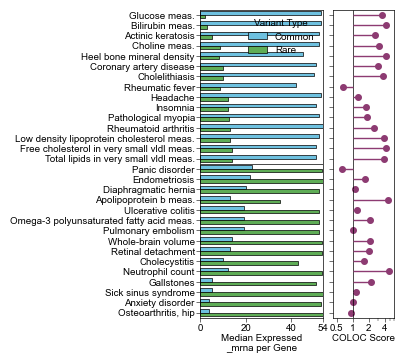

In [289]:
purple = '#8d3b72'
# do I take out the ones without relevant tissues? Probably. 
_ , [ax1, ax2] = plt.subplots(nrows=1, ncols=2, sharey=True, figsize= (2.5, 4), gridspec_kw={'width_ratios': [1, 0.5], 'wspace':0.1})
sns.barplot(bio_df, y='EFO', x='n_mrna', hue='Variant Type', palette=[blue, green], edgecolor='black', order=a.EFO.values, saturation=1, ax=ax1, width=0.7)
ax1.tick_params(axis='y', rotation=0)
_ = ax1.set_yticks(ax1.get_yticks(), labels=[clean_label(best_df.set_index('EFO')['Trait'].to_dict()[x]) for x in a.EFO.values], rotation=0, ha='right')
_ = ax1.set_xticks([0, 20, 40, 54])
ax1.set_xlim(0, 54)
sns.pointplot(best_df, y='EFO', x='Log2SizeOE', order=a.EFO.values, color=purple, ax=ax2, markersize=3, linestyle='None')
ax2.vlines(x=0, ymin=-0.5, ymax=29.5, color='black', linewidth=0.5)
ax2.set_ylim(29.5, -0.5)
coloc = best_df[best_df.EFO.isin(a.EFO.values)].set_index('EFO').Log2SizeOE.to_dict()
for x in a.EFO.values:
    ax2.hlines(y=x, xmin=min(0, coloc[x]), xmax=max(0, coloc[x]), color=purple, linewidth=1)
ax2.set_xlim(-1.25, 2.5)

ax2.set_xticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
_ = ax2.set_xticks(np.log2([3,5,6]), minor=True)
ax2.set_xlabel('COLOC Score')
ax1.set_xlabel('Median Expressed\n_mrna per Gene')
ax1.hlines(y=14.5, xmin=0, xmax=54, color='black', linewidth=0.5)
ax1.set_ylabel('')


### Figure 5B

0.004497409531734475


(-0.5, 1.6)

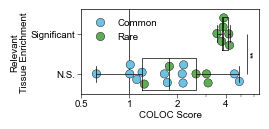

In [290]:
all_ts['test'] = all_ts.Log10PValue > -1 * np.log10(0.05)
from scipy.stats import mannwhitneyu
p = mannwhitneyu(all_ts[all_ts.test].Log2SizeOE.values, all_ts[~all_ts.test].Log2SizeOE.values).pvalue
print(p)
_ = plt.figure(figsize=(2.3,1.1))
ax2 = plt.gca() 
ax2.vlines(x=0, ymin=-0.5, ymax=1.6, color='black', linestyle='-', linewidth=0.5)
sns.swarmplot(all_ts, y='test', x='Log2SizeOE', alpha=1, hue='Group', palette=[blue, green], s=6, edgecolor='black', 
              linewidth=0.3, zorder=2, orient='h')
sns.boxplot(all_ts, y='test', x='Log2SizeOE',fliersize=0,  fill=False, color='black', 
            linewidth=0.5, zorder=3, orient='h')
plt.ylabel('Relevant\nTissue Enrichment')
plt.text(2.6, 0.5, f'**', ha='center', va='center', fontsize=7, rotation=90)
plt.xlim(-1,2.6)

ax2.set_xticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
_ = ax2.set_xticks(np.log2([3,5,6, 7]), minor=True)
ax2.set_xlabel('COLOC Score')
ax2.set_yticks([1,0], labels = ['Significant', 'N.S.'])
ax2.vlines(x=2.45, ymin=0, ymax=1, color='black', linestyle='-', linewidth=0.5)
plt.xlim(-1,2.7)
ax2.set_ylim(-0.5, 1.6)


### Glucose Measurement

In [291]:
glucose = 'EFO_0004468'

In [292]:
print(f'Glucose measurement COLOC Score: {2*(best_df[best_df.EFO==glucose].Log2SizeOE.values[0]):.2f}')

Glucose measurement COLOC Score: 3.64


In [293]:
bio_df.set_index('EFO').loc[glucose]

,sHet,Length,nGO,mrna,n_mrna,Variant Type,Study Identifier
EFO,,,,,,,
EFO_0004468,0.027840,107884.0,20.5,13.610350,53.0,Common,GCST90092819
EFO_0004468,0.001126,8709.0,9.0,0.224811,2.0,Rare,34226706


In [295]:
glucose_rare_set = pd.read_csv(os.path.join(datadir, 'outputs/34226706_EFO_0004468_RV.txt'), sep='\t')

### Figure 5D

In [296]:
kegg_data = pd.read_csv(os.path.join(datadir, 'outputs/gProfiler_hsapiens_5-19-2025_11-22-48 AM__intersections.csv'), sep=',')
kegg_data['GeneRatio'] = kegg_data['intersection_size']/kegg_data['query_size']
kegg_data['TermRatio'] = kegg_data['intersection_size']/kegg_data['term_size']
# filter the kegg data
kegg_data = kegg_data[(kegg_data['adjusted_p_value'] < 0.05)]
kegg_data = kegg_data[kegg_data['intersection_size'] > 20]
kegg_data = kegg_data[kegg_data['term_size'] < 1000]
kegg_data = kegg_data.sort_values(by='adjusted_p_value', ascending=True).drop_duplicates(subset='term_name')

In [297]:
hp_data = kegg_data[kegg_data.source=='HP']
kegg_data = kegg_data[kegg_data.source=='KEGG']

In [298]:
hp_data.head()

,source,term_name,term_id,adjusted_p_value,negative_log10_of_adjusted_p_value,term_size,query_size,intersection_size,effective_domain_size,intersections,GeneRatio,TermRatio
292,HP,Abnormal waist to hip ratio,HP:0031818,7.517890e-20,19.123904,35,235,23,5080,"8660,8431,7466,7352,6934,6928,6927,6833,6514,5...",0.097872,0.657143
291,HP,Increased waist to hip ratio,HP:0031819,7.517890e-20,19.123904,35,235,23,5080,"8660,8431,7466,7352,6934,6928,6927,6833,6514,5...",0.097872,0.657143
302,HP,Abnormal glucose homeostasis,HP:0011014,7.982355e-10,9.097869,687,235,72,5080,"9971,9095,8788,8660,8462,763,7466,7351,7274,69...",0.306383,0.104803
305,HP,Abnormal circulating organic compound concentr...,HP:0430071,2.713287e-09,8.566504,754,235,75,5080,"9971,9420,8788,8647,84699,763,7498,7351,7274,7...",0.319149,0.099469
311,HP,Type II diabetes mellitus,HP:0005978,1.374913e-08,7.861725,137,235,27,5080,"8660,8462,7466,6934,6928,6927,6833,6690,6514,6...",0.114894,0.197080


In [299]:
term_sims = np.zeros((len(kegg_data), len(kegg_data)))
intersection_sets = {}
for i in tqdm(range(len(kegg_data))):
    intersection_sets[i] = set(kegg_data.iloc[i].intersections.split(','))
    term_sims[i, i] = 1
for i in tqdm(range(len(kegg_data))):
    for j in range(i+1, len(kegg_data)):
        term_sims[i, j] = len(intersection_sets[i].intersection(intersection_sets[j]))/len(intersection_sets[i].union(intersection_sets[j]))
        term_sims[j, i] = term_sims[i, j]

100%|██████████| 19/19 [00:00<00:00, 29191.13it/s]


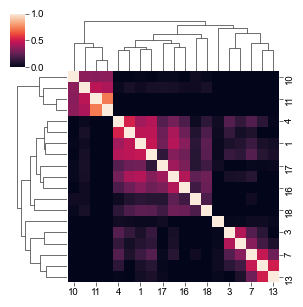

In [300]:
cg = sns.clustermap(term_sims, figsize=(3,3))
order= cg.dendrogram_row.reordered_ind[4:] + cg.dendrogram_row.reordered_ind[:4]

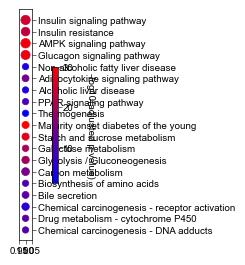

In [301]:
import matplotlib as mpl
_ = plt.figure(figsize=(0.5, 3))
order = order[::-1]
cmap_blended = sns.blend_palette(["blue", 'red'], as_cmap=True)
norm = mpl.colors.Normalize(vmin=-1*np.log10(0.05), vmax=30)
scatter = plt.scatter(
    x=np.ones_like(kegg_data.iloc[order]['term_name']),  # constant x to align vertically
    y=kegg_data.iloc[order]['term_name'],
    c=kegg_data.iloc[order]['negative_log10_of_adjusted_p_value'],
    s=kegg_data.iloc[order]['intersection_size'],  # scale size if needed
    cmap=cmap_blended,
    norm=norm
)
cbar = plt.colorbar(scatter, pad=0.5)
cbar.set_label('-log10(adjusted p-value)', rotation=270, labelpad=15)
plt.gca().yaxis.tick_right()
plt.ylabel("")


In [302]:
kegg_data[kegg_data.term_name.isin(['AMPK signaling pathway', 'Glucagon signaling pathway', 'Insulin signaling pathway', 'Insulin resistance'])]

,source,term_name,term_id,adjusted_p_value,negative_log10_of_adjusted_p_value,term_size,query_size,intersection_size,effective_domain_size,intersections,GeneRatio,TermRatio
1,KEGG,AMPK signaling pathway,KEGG:04152,3.472801e-29,28.459320,120,386,46,8484,"9370,92579,90993,8789,8660,84699,79602,6720,65...",0.119171,0.383333
2,KEGG,Glucagon signaling pathway,KEGG:04922,2.230667e-28,27.651565,107,386,43,8484,"92579,91860,90993,8789,84699,816,6514,5837,583...",0.111399,0.401869
4,KEGG,Insulin signaling pathway,KEGG:04910,1.505333e-25,24.822368,137,386,45,8484,"92579,91860,90673,89801,8789,8660,80201,79660,...",0.116580,0.328467
5,KEGG,Insulin resistance,KEGG:04931,7.507778e-24,23.124489,108,386,39,8484,"92579,90993,90673,8660,84699,79660,6720,6517,6...",0.101036,0.361111


In [303]:
hp_data = hp_data.sort_values(by='adjusted_p_value', ascending=True)
hp_data = hp_data[hp_data.adjusted_p_value< 5e-5]

In [304]:
term_sims = np.zeros((len(hp_data), len(hp_data)))
intersection_sets = {}
for i in tqdm(range(len(hp_data))):
    intersection_sets[i] = set(hp_data.iloc[i].intersections.split(','))
    term_sims[i, i] = 1
for i in tqdm(range(len(hp_data))):
    for j in range(i+1, len(hp_data)):
        term_sims[i, j] = len(intersection_sets[i].intersection(intersection_sets[j]))/len(intersection_sets[i].union(intersection_sets[j]))
        term_sims[j, i] = term_sims[i, j]

100%|██████████| 19/19 [00:00<00:00, 21911.40it/s]


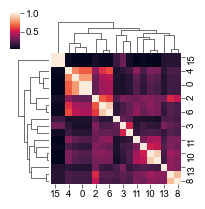

In [305]:
cg2 = sns.clustermap(term_sims, figsize=(2,2))
order= cg2.dendrogram_row.reordered_ind#[4:] + cg.dendrogram_row.reordered_ind[:4]

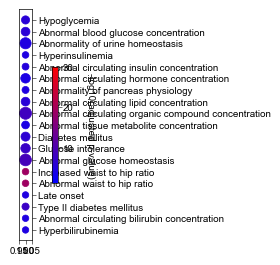

In [306]:
import matplotlib as mpl

cmap_blended = sns.blend_palette(["blue", 'red'], as_cmap=True)
norm = mpl.colors.Normalize(vmin=-1*np.log10(0.05), vmax=30)
_ = plt.figure(figsize=(0.5, 3))
scatter = plt.scatter(
    x=np.ones_like(hp_data.iloc[order]['term_name']),  # constant x to align vertically
    y=hp_data.iloc[order]['term_name'],
    c=hp_data.iloc[order]['negative_log10_of_adjusted_p_value'],
    s=hp_data.iloc[order]['intersection_size'],  # scale size if needed
    cmap=cmap_blended,
    norm=norm
)
cbar = plt.colorbar(scatter, pad=0.5)
cbar.set_label('-log10(adjusted p-value)', rotation=270, labelpad=15)
plt.gca().yaxis.tick_right()
plt.ylabel("")


In [307]:
hp_data[hp_data.term_name.isin(['Increased waist to hip ratio', 'Type II diabetes mellitus'])]

,source,term_name,term_id,adjusted_p_value,negative_log10_of_adjusted_p_value,term_size,query_size,intersection_size,effective_domain_size,intersections,GeneRatio,TermRatio
291,HP,Increased waist to hip ratio,HP:0031819,7.517890e-20,19.123904,35,235,23,5080,"8660,8431,7466,7352,6934,6928,6927,6833,6514,5...",0.097872,0.657143
311,HP,Type II diabetes mellitus,HP:0005978,1.374913e-08,7.861725,137,235,27,5080,"8660,8462,7466,6934,6928,6927,6833,6690,6514,6...",0.114894,0.197080


### Enrichment of prioritized/non-prioritized inputs

In [325]:
non_prt = pd.read_csv(os.path.join(datadir, 'outputs/gProfiler_NONprioritizedInputs.csv'), sep=',')
non_prt['GeneRatio'] = non_prt['intersection_size']/non_prt['query_size']
non_prt['TermRatio'] = non_prt['intersection_size']/non_prt['term_size']

In [326]:
prt = pd.read_csv(os.path.join(datadir, 'outputs/gProfiler_PrioritizedInputs.csv'), sep=',')
prt['GeneRatio'] = prt['intersection_size']/prt['query_size']
prt['TermRatio'] = prt['intersection_size']/prt['term_size']

In [327]:
non_prt[non_prt.intersection_size > 1]

,source,term_name,term_id,adjusted_p_value,negative_log10_of_adjusted_p_value,term_size,query_size,intersection_size,effective_domain_size,intersections,GeneRatio,TermRatio


In [329]:
len(prt)

25

In [330]:
plot_prt= prt[(prt.intersection_size > 1) & (prt.source=='KEGG')].sort_values('adjusted_p_value')[0:10].copy().reset_index(drop=True).reset_index()

In [331]:
plot_hp= prt[(prt.intersection_size > 1) & (prt.source=='HP')].sort_values('adjusted_p_value')[0:10].copy().reset_index(drop=True).reset_index()

In [316]:
plot_hp

,index,source,term_name,term_id,adjusted_p_value,negative_log10_of_adjusted_p_value,term_size,query_size,intersection_size,effective_domain_size,intersections,GeneRatio,TermRatio
0,0,HP,Increased waist to hip ratio,HP:0031819,0.000010,4.994386,35,6,4,5080,"169026,2645,6514,6934",0.666667,0.114286
1,1,HP,Abnormal waist to hip ratio,HP:0031818,0.000010,4.994386,35,6,4,5080,"169026,2645,6514,6934",0.666667,0.114286
2,2,HP,Insulin resistance,HP:0000855,0.000727,3.138437,110,6,4,5080,"169026,2645,6514,6934",0.666667,0.036364
3,3,HP,Type II diabetes mellitus,HP:0005978,0.001052,2.977979,137,6,4,5080,"169026,2645,6514,6934",0.666667,0.029197
4,4,HP,Late onset,HP:0003584,0.001052,2.977979,136,6,4,5080,"169026,2645,6514,6934",0.666667,0.029412
5,5,HP,Diabetes mellitus,HP:0000819,0.039716,1.401036,361,6,4,5080,"169026,2645,6514,6934",0.666667,0.011080
6,6,HP,Glucose intolerance,HP:0001952,0.039716,1.401036,374,6,4,5080,"169026,2645,6514,6934",0.666667,0.010695
7,7,HP,Abnormality of the endocrine system,HP:0000818,0.046086,1.336435,1438,6,6,5080,"111,169026,2645,6239,6514,6934",1.000000,0.004172


### SFigure 5 - Additional Glucose measurement enrichments

In [318]:
plot_prt = plot_prt.sort_values('negative_log10_of_adjusted_p_value', ascending=True)

([], [])

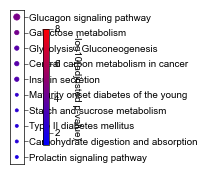

In [319]:
import matplotlib as mpl
_ = plt.figure(figsize=(0.5, 2))
cmap_blended = sns.blend_palette(["blue", 'red'], as_cmap=True)
norm = mpl.colors.Normalize(vmin=-1*np.log10(0.05), vmax=8)
scatter= plt.scatter(x=np.ones_like(plot_prt['term_name']),
            y=plot_prt['term_name'], 
            c = plot_prt['negative_log10_of_adjusted_p_value'], 
            s=(2**plot_prt['intersection_size'])*1.25,
            cmap=cmap_blended, norm=norm)
cbar = plt.colorbar(scatter, pad=0.5)
cbar.set_label('-log10(adjusted p-value)', rotation=270, labelpad=15)
plt.gca().yaxis.tick_right()
plt.ylabel("")
plt.xticks([])

In [320]:
plot_hp = plot_hp.sort_values('negative_log10_of_adjusted_p_value', ascending=True)

In [321]:
plot_hp

,index,source,term_name,term_id,adjusted_p_value,negative_log10_of_adjusted_p_value,term_size,query_size,intersection_size,effective_domain_size,intersections,GeneRatio,TermRatio
7,7,HP,Abnormality of the endocrine system,HP:0000818,0.046086,1.336435,1438,6,6,5080,"111,169026,2645,6239,6514,6934",1.000000,0.004172
5,5,HP,Diabetes mellitus,HP:0000819,0.039716,1.401036,361,6,4,5080,"169026,2645,6514,6934",0.666667,0.011080
6,6,HP,Glucose intolerance,HP:0001952,0.039716,1.401036,374,6,4,5080,"169026,2645,6514,6934",0.666667,0.010695
3,3,HP,Type II diabetes mellitus,HP:0005978,0.001052,2.977979,137,6,4,5080,"169026,2645,6514,6934",0.666667,0.029197
4,4,HP,Late onset,HP:0003584,0.001052,2.977979,136,6,4,5080,"169026,2645,6514,6934",0.666667,0.029412
2,2,HP,Insulin resistance,HP:0000855,0.000727,3.138437,110,6,4,5080,"169026,2645,6514,6934",0.666667,0.036364
0,0,HP,Increased waist to hip ratio,HP:0031819,0.000010,4.994386,35,6,4,5080,"169026,2645,6514,6934",0.666667,0.114286
1,1,HP,Abnormal waist to hip ratio,HP:0031818,0.000010,4.994386,35,6,4,5080,"169026,2645,6514,6934",0.666667,0.114286


In [ ]:
import matplotlib as mpl
_ = plt.figure(figsize=(0.5, 2))
cmap_blended = sns.blend_palette(["blue", 'red'], as_cmap=True)
norm = mpl.colors.Normalize(vmin=-1*np.log10(0.05), vmax=8)
scatter= plt.scatter(x=np.ones_like(plot_hp['term_name']),
            y=plot_hp['term_name'], 
            c = plot_hp['negative_log10_of_adjusted_p_value'], 
            s=(2**plot_hp['intersection_size'])*1.25,
            cmap=cmap_blended, norm=norm)
cbar = plt.colorbar(scatter, pad=0.5)
cbar.set_label('-log10(adjusted p-value)', rotation=270, labelpad=15)
plt.gca().yaxis.tick_right()
plt.ylabel("")
plt.xticks([])
